In [1]:
# Shuyang Li, “INTERVIEW: NPR Media Dialog Transcripts.” Kaggle, doi: 10.34740/KAGGLE/DS/590180.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import string
from altair import Chart, X, Y, Color, Scale
import altair as alt
from vega_datasets import data
import matplotlib
import matplotlib.pyplot as plt
import psycopg2
import wordcloud
import textatistic
import seaborn as sbn
import requests
import json
from bs4 import BeautifulSoup
from collections import Counter
import re
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
nltk.download('stopwords') 
nltk.download('punkt')

matplotlib.style.use('ggplot')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nanamathis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nanamathis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nanamathis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Reading in data
#### If you want to skip reading, cleaning, and merging, go to the header labeled: [Download Ready To Go Data](#Download-Ready-To-Go-Data)

### First reading the .csv files:
- episodes: information on each episode by id, includes the program it's under, title, and date which is parsed as a date
- utter2: record of episode content when there are only 2 people in speaking in the episode
- utter: record of episode content when there are any number of people in speaking in the episode

In [3]:
episodes = pd.read_csv('interview-npr-media-dialog-transcripts/episodes.csv',parse_dates=['episode_date'])
utter2 = pd.read_csv('interview-npr-media-dialog-transcripts/utterances-2sp.csv')
utter = pd.read_csv('interview-npr-media-dialog-transcripts/utterances.csv')

### Now reading the .json files:
- host_ids: host names with their id number
- host_map: by host id, includes name, list of episodes id's, and list of programs 
- test_train_valid: the data split into train, test, validate for any modeling

In [6]:
host_ids = pd.read_json('interview-npr-media-dialog-transcripts/host_id.json',orient='index')
host_map = pd.read_json('interview-npr-media-dialog-transcripts/host-map.json',orient='index')
test_train_valid = pd.read_json('interview-npr-media-dialog-transcripts/splits-ns2.json',orient='index')

# Cleaning the data
Right now we don't need the train_test_valid dataset so we will leave it alone. We will be cleaning and organizing the rest of the data.

In the episodes dataset we will rename 'id' to be 'episode_id' to be clear since the hosts have ids as well. 

In [7]:
episodes.rename(columns={'id':'episode_id'},inplace=True)
episodes.head()

,episode_id,program,title,episode_date
0,98814,Morning Edition,Senate Ushers In New Year With 'Fiscal Cliff' ...,2013-01-01
1,98824,Morning Edition,Cheap Bubbly Or Expensive Sparkling Wine? Look...,2012-12-31
2,98821,Morning Edition,U.S. Gas Prices Reach Record Level In 2012,2013-01-01
3,98806,Morning Edition,House Approves 'Fiscal Cliff' Measure,2013-01-02
4,98823,Morning Edition,The Fiscal Cliff: A Love Story,2012-12-31


I don't know if I'll use the utter2 dataset since the utter dataset covers the episodes in it as well but we will change the name of the column 'id' to 'episode_id' to match the other dataset variables. We will also clean the text of what they said so it's all uniform.

In [8]:
utter.rename(columns={'episode':'episode_id'},inplace=True)
utter2.rename(columns={'episode':'episode_id'},inplace=True)

In [9]:
# convert all text to lower case
utter['utterance'] = utter.utterance.str.lower()
utter2['utterance'] = utter2.utterance.str.lower()
# remove strange character
utter['utterance'] = utter.utterance.str.replace('\ufeff','') 
utter2['utterance'] = utter2.utterance.str.replace('\ufeff','')
# eliminate whitespace from beginning and end
utter['utterance'] = utter.utterance.str.strip() 
utter2['utterance'] = utter2.utterance.str.strip()
# splits the text into a list of words/strings
utter['utter_text'] = utter.utterance.str.split() 
utter2['utter_text'] = utter2.utterance.str.split()

utter.head()

,episode_id,episode_order,speaker,utterance,utter_text
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","it's a 2,200-mile race. to give some sense of ...","[it's, a, 2,200-mile, race., to, give, some, s..."
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",so for a top competitor like lance to try to m...,"[so, for, a, top, competitor, like, lance, to,..."
2,57264,11,"NEAL CONAN, host","so in every team, presumably there's one star,...","[so, in, every, team,, presumably, there's, on..."
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",that's right. each team has nine riders. and w...,"[that's, right., each, team, has, nine, riders..."
4,57264,13,"NEAL CONAN, host","so slipstream, this is like drafting in car ra...","[so, slipstream,, this, is, like, drafting, in..."


In [10]:
# clean up speaker column to make all host names be lower case as well as
# remove the text ", host" so it will match with the hosts datasets
utter['speaker'] = utter.speaker.str.lower()
utter['speaker'] = x = utter.speaker.str.replace(', host','',regex=False)
utter.head()

,episode_id,episode_order,speaker,utterance,utter_text
0,57264,9,"ms. loren mooney (editor-in-chief, bicycling m...","it's a 2,200-mile race. to give some sense of ...","[it's, a, 2,200-mile, race., to, give, some, s..."
1,57264,10,"ms. loren mooney (editor-in-chief, bicycling m...",so for a top competitor like lance to try to m...,"[so, for, a, top, competitor, like, lance, to,..."
2,57264,11,neal conan,"so in every team, presumably there's one star,...","[so, in, every, team,, presumably, there's, on..."
3,57264,12,"ms. loren mooney (editor-in-chief, bicycling m...",that's right. each team has nine riders. and w...,"[that's, right., each, team, has, nine, riders..."
4,57264,13,neal conan,"so slipstream, this is like drafting in car ra...","[so, slipstream,, this, is, like, drafting, in..."


Cleaning up host_map so it makes more sense and organized. Also rename the name column to be speaker so that we can merge it with the episodes dataset.

In [11]:
# the index actually corresponds to the host_id so we are
# sorting by index and then reseting the index to be a column
host_map.sort_index(axis=0,inplace=True)
host_map.reset_index(inplace=True)
# renaming index column to be host_id and reordering the columns
host_map.rename(columns={'index':'host_id','name':'speaker'},inplace=True)
host_map = host_map[['speaker','host_id','episodes','programs']]
host_map.head()

,speaker,host_id,episodes,programs
0,lulu garcia-navarro,0,"[512, 1, 2, 513, 515, 6, 518, 519, 6670, 6671,...",[Weekend Edition Sunday]
1,melissa block,1,"[137216, 129027, 139267, 135177, 135178, 13722...","[Weekend Edition Saturday, Weekend Edition Sun..."
2,leila fadel,2,"[75, 77, 79, 339, 83, 342, 344, 345, 349, 350]",[Weekend Edition Sunday]
3,susan davis,3,"[185, 563, 189, 191]",[Weekend Edition Sunday]
4,sacha pfeiffer,4,"[387, 389, 391, 8085, 8088, 8089, 8090, 673, 6...","[Weekend Edition Saturday, Weekend Edition Sun..."


In [12]:
# TODO: clean up names for hosts, it's an issue in both host_ids and host_map
# there are double counts like "text melissa block" and "melissa block" and
# "mr. neal conan" vs. "neal conan"
# some aren't even included in the host data, i.e. mara liasson, byline is listed as guest
# x = host_map.name.str.extractall('(global)(\s\w+)',flags=re.IGNORECASE)

Cleaning up host_ids to be sorted by their id, we also renamed the name column to be speaker so that we can merge it with the episodes dataset.

In [13]:
host_ids.sort_values(by=0,ascending=True,inplace=True)
host_ids.reset_index(inplace=True)
host_ids.rename(columns={'index':'speaker',0:'host_id'},inplace=True)
host_ids.head()

,speaker,host_id
0,lulu garcia-navarro,0
1,melissa block,1
2,leila fadel,2
3,susan davis,3
4,sacha pfeiffer,4


# Merging datasets

epScript is a dataframe merging episodes and utter so that we have all the information of an episode and the script. 

In [14]:
epScript = pd.merge(utter,episodes,on='episode_id',how='left')
epScript.head()

,episode_id,episode_order,speaker,utterance,utter_text,program,title,episode_date
0,57264,9,"ms. loren mooney (editor-in-chief, bicycling m...","it's a 2,200-mile race. to give some sense of ...","[it's, a, 2,200-mile, race., to, give, some, s...",Talk of the Nation,How To Watch The Tour De France,2010-07-12
1,57264,10,"ms. loren mooney (editor-in-chief, bicycling m...",so for a top competitor like lance to try to m...,"[so, for, a, top, competitor, like, lance, to,...",Talk of the Nation,How To Watch The Tour De France,2010-07-12
2,57264,11,neal conan,"so in every team, presumably there's one star,...","[so, in, every, team,, presumably, there's, on...",Talk of the Nation,How To Watch The Tour De France,2010-07-12
3,57264,12,"ms. loren mooney (editor-in-chief, bicycling m...",that's right. each team has nine riders. and w...,"[that's, right., each, team, has, nine, riders...",Talk of the Nation,How To Watch The Tour De France,2010-07-12
4,57264,13,neal conan,"so slipstream, this is like drafting in car ra...","[so, slipstream,, this, is, like, drafting, in...",Talk of the Nation,How To Watch The Tour De France,2010-07-12


We will also add the host_id to this frame and fill guest speakers' id or any unfilled values as -1. Then we will sort the dataframe by episode_id following episode order. Then we sort the episodes by date and if there are multiple episodes on a day, by their episode_id and also the order of the script, episode_order. We will also keep track of the number of words in a given utterance with 'word_count.'

In [15]:
epScript = pd.merge(epScript,host_ids,on='speaker',how="outer")
epScript.fillna(-1, inplace=True)
epScript.sort_values(by=['episode_date','episode_id','episode_order'],inplace=True,ascending=True)
epScript.reset_index(drop=True,inplace=True)
epScript['word_count'] = epScript.utter_text.str.len()
epScript.head()

,episode_id,episode_order,speaker,utterance,utter_text,program,title,episode_date,host_id,word_count
0,141179,0,noah adams,"by contrast, the airport renaming appears to b...","[by, contrast,, the, airport, renaming, appear...",All Things Considered,Airport Samba,1999-01-08,34.0,20.0
1,141179,1,isabelle deluca,everybody loves mr. jobim here. he's like our ...,"[everybody, loves, mr., jobim, here., he's, li...",All Things Considered,Airport Samba,1999-01-08,-1.0,107.0
2,141179,2,noah adams,you mentioned the airport samba?,"[you, mentioned, the, airport, samba?]",All Things Considered,Airport Samba,1999-01-08,34.0,5.0
3,141179,3,isabelle deluca,yes.,[yes.],All Things Considered,Airport Samba,1999-01-08,-1.0,1.0
4,141179,4,noah adams,written by mr. jobim.,"[written, by, mr., jobim.]",All Things Considered,Airport Samba,1999-01-08,34.0,4.0


Creating a dataframe, bySpeaker, that has been grouped by the speaker and the non-repeating valued columns will then be concatenated to a list. We know that the index of one list, say at index 0 in episode_id, correlates to the program at index 0. We also will add a row to keep the total count of words said in a given episode with 'total_count.'

In [16]:
bySpeaker = epScript.groupby(['speaker','host_id']
                            )['episode_id','episode_order','utterance','program',
                              'title','episode_date','word_count'].agg(list).reset_index()
bySpeaker.sort_values(by=['speaker','host_id'],inplace=True,ascending=True)
bySpeaker.reset_index(drop=True,inplace=True)
bySpeaker['total_count'] = bySpeaker.word_count.apply(lambda l: np.nansum(l))
bySpeaker.head()

,speaker,host_id,episode_id,episode_order,utterance,program,title,episode_date,word_count,total_count
0,.paak,-1.0,"[35072, 35072, 35072, 35072, 35072, 35072, 350...","[5, 7, 9, 11, 14, 17, 19, 21, 23, 25, 27, 31, ...","[you want to pop it now?, let's pop it now., y...","[Morning Edition, Morning Edition, Morning Edi...",[Anderson .Paak Comes Home: 'This Is What We D...,"[2018-11-19 00:00:00, 2018-11-19 00:00:00, 201...","[6.0, 4.0, 4.0, 8.0, 32.0, 17.0, 5.0, 24.0, 20...",1123.0
1,_no_speaker,-1.0,"[85620, 85620, 135286, 134619, 84651, 84651, 8...","[5, 16, 34, 0, 69, 147, 45, 51, 0, 44, 104, 40...","[(soundbite from ad), (soundbite of gun being ...","[Weekend Edition Saturday, Weekend Edition Sat...","[Iraqis Vote for Local Council, Iraqis Vote fo...","[2004-02-14 00:00:00, 2004-02-14 00:00:00, 200...","[3.0, 5.0, 3.0, nan, 3.0, 1.0, 3.0, 5.0, 742.0...",751277.0
2,a,-1.0,"[121059, 121059, 116731, 116731, 123074, 71762...","[3, 7, 0, 2, 4, 4, 5, 0, 0, 6, 0, 0, 4, 15, 5,...",[not all of them friendly to the united states...,"[Morning Edition, Morning Edition, Morning Edi...","[Judge: Navy Not Exempt from Sonar Ban, Judge:...","[2008-02-05 00:00:00, 2008-02-05 00:00:00, 200...","[45.0, 44.0, 19.0, 6.0, 12.0, 31.0, 21.0, 39.0...",1710.0
3,a s,-1.0,[110760],[0],[npr's brian naylor reports.],[Morning Edition],[Mine Deaths Stir New Debate On Federal Oversi...,[2010-04-27 00:00:00],[4.0],4.0
4,a v,-1.0,"[127810, 127810]","[4, 5]","[a visit to cuba., here's npr's greg allen.]","[Morning Edition, Morning Edition]","[Miami Schools Try to Ban Cuba Book, Miami Sch...","[2006-08-23 00:00:00, 2006-08-23 00:00:00]","[4.0, 4.0]",8.0


Creating a similar dataframe except it will only include the hosts.

In [17]:
byHost = pd.merge(host_ids,bySpeaker,on=['speaker','host_id'],how='left')
byHost = byHost[['speaker','host_id','episode_id','episode_order','utterance',
                 'program','title','episode_date','word_count','total_count']]
byHost.head()

,speaker,host_id,episode_id,episode_order,utterance,program,title,episode_date,word_count,total_count
0,lulu garcia-navarro,0,"[29883, 29883, 8981, 8982, 8983, 8983, 8983, 8...","[1, 2, 1, 1, 1, 3, 6, 8, 11, 13, 16, 18, 1, 15...","[around the country, people are holding rallie...","[Weekend Edition Sunday, Weekend Edition Sunda...",[Hundreds Protest Trump At California Congress...,"[2017-02-05 00:00:00, 2017-02-05 00:00:00, 201...","[24.0, 29.0, 64.0, 65.0, 73.0, 6.0, 9.0, 12.0,...",187510.0
1,melissa block,1,"[140734, 140734, 140734, 140734, 140734, 14073...","[3, 4, 5, 9, 11, 16, 18, 20, 22, 1, 1, 1, 2, 3...","[and i'm melissa block., she is inextricably l...","[All Things Considered, All Things Considered,...",[Lynndie England Pleads Guilty to Prisoner Abu...,"[2005-05-02 00:00:00, 2005-05-02 00:00:00, 200...","[4.0, 56.0, 9.0, 9.0, 10.0, 44.0, 7.0, 4.0, 8....",1141651.0
2,leila fadel,2,"[113279, 113279, 113279, 113279, 113279, 347, ...","[5, 7, 9, 11, 13, 1, 3, 5, 7, 9, 11, 13, 15, 1...",[i think the general feeling was giddiness - r...,"[All Things Considered, All Things Considered,...","[Tunisians Vote In Free Elections, Tunisians V...","[2011-10-23 00:00:00, 2011-10-23 00:00:00, 201...","[61.0, 85.0, 80.0, 89.0, 5.0, 108.0, 19.0, 26....",6482.0
3,susan davis,3,"[89491, 89491, 89491, 89491, 89491, 89491, 894...","[2, 3, 6, 8, 9, 12, 14, 15, 17, 18, 20, 22, 15...",[the speaker has increasingly been put in a po...,"[All Things Considered, All Things Considered,...",[House Speaker Paul Ryan Delivers Critical Spe...,"[2016-03-23 00:00:00, 2016-03-23 00:00:00, 201...","[70.0, 28.0, 37.0, 38.0, 63.0, 37.0, 73.0, 59....",3341.0
4,sacha pfeiffer,4,"[110093, 110093, 110093, 110093, 110093, 11009...","[3, 5, 7, 9, 11, 13, 15, 18, 3, 5, 7, 8, 10, 1...","[but none of these women have lean, sculpted b...","[Morning Edition, Morning Edition, Morning Edi...",[Nonprofit Gym Helps Low-Income Community Get ...,"[2010-06-17 00:00:00, 2010-06-17 00:00:00, 201...","[24.0, 6.0, 59.0, 25.0, 76.0, 17.0, 26.0, 8.0,...",11976.0


Creating another dataframe like bySpeaker, byEpisode, that has been grouped by the episode_id and the non-repeating valued columns will then be concatenated to a list. We know that the index of one list, say at index 0 in host_id, correlates to the speaker name at index 0. We also will add a row to keep the total count of words said in a given episode with 'total_count.'

In [18]:
byEpisode = epScript.groupby(['episode_id','program','title','episode_date']
                             )['speaker','utterance','host_id','word_count'].agg(list).reset_index()
byEpisode.sort_values(by=['episode_date','episode_id'],inplace=True,ascending=True)
byEpisode.reset_index(drop=True,inplace=True)
byEpisode['total_count'] = byEpisode.word_count.apply(lambda l: np.nansum(l))
byEpisode.head()

,episode_id,program,title,episode_date,speaker,utterance,host_id,word_count,total_count
0,141179,All Things Considered,Airport Samba,1999-01-08,"[noah adams, isabelle deluca, noah adams, isab...","[by contrast, the airport renaming appears to ...","[34.0, -1.0, 34.0, -1.0, 34.0, -1.0, 34.0, -1....","[20.0, 107.0, 5.0, 1.0, 4.0, 1.0, 6.0, 65.0, 3...",425.0
1,85414,Weekend Edition Sunday,Iraq WMD Questioned,2004-01-25,"[liane hansen, david kay, liane hansen, david ...","[on friday, cia director george tenet announce...","[117.0, -1.0, 117.0, -1.0, 117.0, -1.0, 117.0,...","[132.0, 141.0, 15.0, 8.0, 16.0, 142.0, 14.0, 8...",2479.0
2,85620,Weekend Edition Saturday,Iraqis Vote for Local Council,2004-02-14,"[scott simon, scott simon, emily harris report...","[in iraq earlier today, guerrillas attacked a ...","[12.0, 12.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[45.0, 101.0, 19.0, 3.0, 3.0, 52.0, 40.0, 74.0...",805.0
3,135286,Morning Edition,Study Sheds Light on Compulsive Hoarding,2004-06-07,"[steve inskeep, michelle trudeau reporting, ri...",[a new study focuses on the brains of compulsi...,"[16.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[47.0, 34.0, 44.0, 58.0, 9.0, 15.0, 36.0, 33.0...",1200.0
4,134619,Morning Edition,Toni Morrison's 'Good' Ghosts,2004-09-20,"[_no_speaker, steve inskeep, steve inskeep, st...","[-1, -1, this is morning edition from npr news...","[-1.0, 16.0, 16.0, 16.0, 16.0, 16.0, 5.0, 5.0,...","[nan, nan, 10.0, nan, 62.0, nan, nan, 65.0, na...",1294.0


# Preparing DataFrames

In [19]:
# I found out that the way I aggregate the utterances together to be a huge list of words, there is an extra 
# [ and ' in the string of the first index and ' and ] in the string of the last index.
def remExtraBrackets(L):
    """
    Removes the extra apostrophes and brackets 
    at the first and last index of a list. 
    Returns the updated list as a string.
    input:
    L (list) - a list of strings with the first and last elements having 2 extra characters in the front and back respectively
    output:
    (string) - string form of the changed list
    """ 
    L[0] = L[0][2:]
    L[-1] = L[-1][:-2]
    # return a string because later we will make a list of the important words
    return ' '.join(L)

#### Grouping the episodes by year where utterance has all scripts from that year as a string and avg_epCount is the average length of an episode that year.

In [20]:
# gathering text by year
textByYear = byEpisode.groupby(byEpisode['episode_date'].dt.year
                               ).agg({'utterance': lambda l:
                                      [word for sentence in l for word in str(sentence).split()],
                                      'total_count': 'mean',
                                     }).reset_index()
textByYear['utterance'] = textByYear.utterance.apply(remExtraBrackets)
textByYear.rename(columns={'total_count':'avg_epCount'},inplace=True)
textByYear.head()

,episode_date,utterance,avg_epCount
0,1999,"by contrast, the airport renaming appears to b...",425.000000
1,2004,"on friday, cia director george tenet announced...",2117.428571
2,2005,this is talk of the nation. i'm neal conan in ...,1157.769123
3,2006,"from npr news, this is weekend edition. i'm li...",1150.902557
4,2007,"from npr news, this is news & notes. i'm farai...",1151.615966


#### Grouping the episodes by program where utterance has all scripts from that program as a string and avg_epCount is the average length of an episode for that program

In [21]:
textByProg = byEpisode.groupby(byEpisode['program']
                               ).agg({'utterance': lambda l:
                                      [word for sentence in l for word in str(sentence).split()],
                                      'total_count': 'mean',
                                     }).reset_index()
textByProg['utterance'] = textByProg.utterance.apply(remExtraBrackets)
textByProg.rename(columns={'total_count':'avg_epCount'},inplace=True)

textByProg.head()

,program,utterance,avg_epCount
0,All Things Considered,"by contrast, the airport renaming appears to b...",774.556907
1,Day to Day,"madeleine brand, co-host:', ""from npr news and...",769.075868
2,Morning Edition,a new study focuses on the brains of compulsiv...,678.580430
3,News & Notes,"from npr news, this is news & notes. i'm ed go...",1464.620318
4,Talk of the Nation,this is talk of the nation. i'm neal conan in ...,3788.100751


Grouping the episodes by host where utterance has all scripts from that host as a string and avg_epCount is the average length of an episode for that host

In [112]:
textByHost = byHost.groupby(byHost['speaker']
                               ).agg({'utterance': lambda l:
                                      [word for sentence in l for word in str(sentence).split()],
                                      'total_count': 'mean',
                                     }).reset_index()
textByHost['utterance'] = textByHost.utterance.apply(remExtraBrackets)
textByHost.rename(columns={'total_count':'avg_epCount'},inplace=True)

textByHost.head()

,speaker,utterance,avg_epCount
0,a l,but a lot of praise for the interview mary lou...,18.0
1,a martinez,"agh. great joke there, tess. by the way, i hat...",3838.0
2,aarti shahani,yeah. it's actually a point many experts in cr...,2973.0
3,adam davidson,walk into condolaria botanica(ph) one of the m...,77115.0
4,ailsa chang,prosecutors are calling it the largest medicar...,146620.0


### Time to clean the text even more! It might have been more efficient to do this before I split and grouped the data in the previous two cells but I'm not sure due to the format it was in as a list of sentences rather than a string. I might try it later but for now we will do it this way.

In [23]:
def replacePunct(S):
    """
    Replaces punctuation with whitespace, eliminating 
    punctuation in a string. Returns the updated string.
    input:
    S (string) - a string that has punctuation characters
    output:
    (string) - new string with punctuation replaced with a space
    """ 
    return S.translate(str.maketrans(
        string.punctuation, ' '*len(string.punctuation)))

In [123]:
# replace punctuation with spaces
textByYear['utterance'] = textByYear.utterance.apply(replacePunct)
textByProg['utterance'] = textByProg.utterance.apply(replacePunct)
textByHost['utterance'] = textByHost.utterance.apply(replacePunct)

In [125]:
# add a new column, called utter_list, to our dataframe,
# by applying the function nltk.word_tokenize to the text column.
textByYear['utter_list'] = textByYear.utterance.apply(nltk.word_tokenize)
textByProg['utter_list'] = textByProg.utterance.apply(nltk.word_tokenize)
textByHost['utter_list'] = textByHost.utterance.apply(nltk.word_tokenize)

In [126]:
# get stopwords, i.e. is, am, etc.
sw = set(stopwords.words('english'))

this keeps only regular English words and removes common words such as is, am, etc.
textByYear['utter_list'] = textByYear.utter_list.apply(
    lambda x: [y for y in x if y not in sw])
textByProg['utter_list'] = textByProg.utter_list.apply(
    lambda x: [y for y in x if y not in sw])
textByHost['utter_list'] = textByHost.utter_list.apply(
    lambda x: [y for y in x if y not in sw])

# Download Ready To Go Data
You can use this to get the DataFrames without doing the work above. First run the cell below and then if you want to skip more cleaning and prepping then you can skip to: [Download More Ready To Go Data](#Download-More-Ready-To-Go-Data)

In [ ]:
epScript = pd.read_csv('from-notebook/transcripts-divided.csv',parse_dates=['episode_date'])
bySpeaker = pd.read_csv('from-notebook/transcripts-by-speaker.csv',parse_dates=['episode_date'])
byEpisode = pd.read_csv('from-notebook/transcripts-by-episode.csv',parse_dates=['episode_date'])
textByYear = pd.read_csv('from-notebook/transcripts-by-year.csv',parse_dates=['episode_date'])
textByProg = pd.read_csv('from-notebook/transcripts-by-program.csv')
textByHost = pd.read_csv('from-notebook/transcripts-by-host.csv')

# Analyzing Data

Some functions to help with charting and plotting the frequency of words

In [60]:
def createCounter(df):
    """
    Creates and returns a Counter for df on the words in 'utter_list'
    input:
    df (DataFrame) - DataFrame you want to count
    output:
    (Counter) - a Counter that has summed the occurences of each word 
    in 'utter_list' of the DataFrame
    """ 
    return Counter(df.utter_list.sum())
def dictOfCounters(df,L):
    for e in L:
        counter = createCounter(df)

In [46]:
yearCounters = {}
for year in textByYear.episode_date:
    counter = createCounter(textByYear)
    yearCounters[year] = counter
    print('finished: ',year)

In [39]:
progCounters = {}r
for program in textByProg.program:
    counter = createCounter(textByProg)
    progCounters[program] = counter
    print('finished: ',program)

In [ ]:
# this doesn't represent the entire dataset since only using a 
# portion of the hosts and excluding the guest speakers
hostCounters = {}
top10Hosts = textByHost.sort_values(by='avg_epCount',inplace=False,ascending=False)[:10]
for host in top10Hosts:
    counter = createCounter(textByHost)
    hostCounters[host] = counter
    print('finished: ',host)

# Download More Ready To Go Data!

In [47]:
with open('from-notebook/yearCounters.txt', 'r') as file:
    yearCounters = json.load(file)
with open('from-notebook/progCounters.txt', 'r') as file:
    progCounters = Counter(json.load(file))
with open('from-notebook/hostCounters.txt', 'r') as file:
    hostCounters = Counter(json.load(file))

In [45]:
def toDictOfCounters(dictionary):
    """
    Converts a dictionary of dictionarys with words 
    and counts and their respective keys and values 
    to a dictionary of Counters
    input:
    dictionary (dict) - dictionary of dictionarys 
    whose keys and values are words and their counts
    output:
    (dict) - a dictionary of Counters
    """
    for key in dictionary.keys():
        dictionary[key] = Counter(dictionary[key])
    return dictionary

In [48]:
yearCounters = toDictOfCounters(yearCounters)
progCounters = toDictOfCounters(progCounters)
hostCounters = toDictOfCounters(hostCounters)

### Frequency Analysis

In [ ]:
def countTopics(df, topics):
    """
    Creates and returns a Counter for df on the words in 'utter_list'
    input:
    df (DataFrame) - DataFrame you want to count
    topics (list) - a list of strings that are topics to count
    output:
    nothing - this function counts the occurences of each string in
    topics in df.utterance column and adds that count to a column 
    with the name of the topic. instead of returning a new DataFrame,
    it changes in place the given df
    """
    for t in topics:
        df[t] = df.text.str.count(t)

Currently looking at the words by years.

In [ ]:
# 4. Find or create a list of topics that the UN might discuss and debate. Make a graph to show how often these topics
# were mentioned. For example: ‘peace’, ‘nuclear war’, ‘terrorism’, ‘moon landing’. You can think of your own!
topics = ['women','female','reproduction',
          'violence', 'health', 'education',
          'assault', 'inequality', 'human rights',
          'abortion', 'feminism', 'regulation']

year_summ = textByYear.groupby('year', as_index=False)['utterance'].sum()
year_summ.head()

countTopics(year_summ, topics)

year_summ = year_summ[['year','women','female','reproduction',
                       'violence', 'health', 'education',
                       'assault', 'inequality', 'human rights',
                       'abortion', 'feminism', 'regulation']]
year_summ.head()

# Altair works better when data is in wide_form so we can easily 
# convert the long form DataFrame using melt().
year_summ = year_summ.melt('year', var_name='word', value_name='count')

In [ ]:
alt.Chart(year_summ).mark_line().encode(
    x='year:O',
    y='count:Q',
    color='word:N'
).properties(
    width=180,
    height=180
).facet(
    facet='word:N',
    columns=3
).interactive()

Combine the graphs to show all the words over all the years.

In [ ]:
# 6. Make a graph to show the frequency with which various topics are discussed over the years. For example, ‘peace’
# is consistently a popular word as is ‘freedom’ and ‘human rights’. What about ‘HIV’ or ‘terrorism’ or ‘global
# warming’. Compare two phrases like ‘global warming’ and ‘climate change’.
alt.Chart(year_summ).mark_line().encode(
    x='year:O',
    y='count:Q',
    color='word:N',
)

#### WordClouds reflecting frequency

In [ ]:
# TODO: FIX

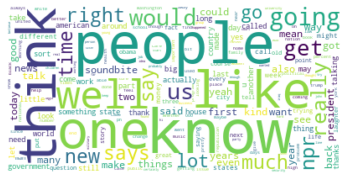

In [36]:
# make WordCloud from the counter
def createWordCloud(counter):
    wc = wordcloud.WordCloud(background_color ='white')
    # generate word cloud
    wc.generate_from_frequencies(frequencies=counter)
#     show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
createWordCloud(progCounters['All Things Considered'])

#### Charting average words per episode

In [ ]:
avgWordsPerEp = byEpisode['total_count'].mean()

# I created a dataframe that just has each year and the avergage
# length of all speeches called source
source = pd.DataFrame({
  'year': textByYear.episode_date,
  'avg': avgWordsPerEp
})
# so that I can create a single horizontal graph that I can
# overlay it with the byYeargraph!
avg = alt.Chart(source).mark_rule(color='red').encode(
    y='avg'
)

In [ ]:
# bars for each year's own average speech length
byYearBar = alt.Chart(textByYear).mark_bar().encode(
    x='year:N',
    y='avg_epCount:Q',
    color='year:N'
)

# compare each country to the average speech length
compare = (byYearBar+avg).properties(width=2000)
compare

In [ ]:
# bars for each year's own average speech length
byProgBar = alt.Chart(textByProg).mark_bar().encode(
    x='program:N',
    y='avg_epCount:Q',
    color='program:N'
)

# compare each country to the average speech length
compare = (byProgBar+avg).properties(width=2000)
compare

In [ ]:
# bars for each year's own average speech length
byHostBar = alt.Chart(textByHost).mark_bar().encode(
    x='speaker:N',
    y='avg_epCount:Q',
    color='speaker:N'
)

# compare each country to the average speech length
compare = (byHostBar+avg).properties(width=2000)
compare

### Sentiment Analysis

In [ ]:
analyzer = SentimentIntensityAnalyzer()

credit goes to Google/Runestone for creating this function
def score_text(text):
    """
    Calculates and returns the sentiment score of a text string
    input:
    text (string) - text you're analyzing the sentiment of
    output:
    (int) - a score between -1 and 1. -1 is the most negative
    sentiment score a text can get and +1 is the most positive 
    """ 
    sentence_list = tokenize.sent_tokenize(text)
    cscore = 0.0
    for sent in sentence_list:
        ss = analyzer.polarity_scores(sent)['compound']
        cscore += ss
    return cscore / len(sentence_list)

In [ ]:
epScript['sentiment'] = undf.text.map(lambda t : score_text(t))

In [ ]:
alt.data_transformers.enable('json')
alt.Chart(epScript).mark_bar().encode(x=X('sentiment', bin=True), y='count()')

In [ ]:
sentByEpisode = epScript.groupby(['episode_id','program','title','episode_date'])['sentiment'].mean
sentBySpeaker = epScript.groupby(['speaker','host_id'])['sentiment'].mean()
sentByHost = pd.merge(host_ids,bySpeaker,on=['speaker','host_id'],how='left')
sentByYear = epScript.groupby(['episode_date'].dt.year)['sentiment'].mean()
sentByProgram = epScript.groupby(['program'])['sentiment'].mean()

#### Charting Sentiment

In [ ]:
# find avg sentiment
avgSent = epScript.sentiment.mean()

# I created a dataframe that just has each year and the avergage
# sentiment in speeches
source = pd.DataFrame({
  'year': sentByYear.year,
  'avg': avgSent
})
# so that I can create a single horizontal graph that I can
# overlay it with the byYear graph
avg = alt.Chart(source).mark_rule(color='red').encode(
    y='avg'
)

In [ ]:
# average sentiment over the years
byYear = alt.Chart(sentByYear).mark_line().encode(
    x='year:O',
    y='sentiment:Q',
)

compare each year's sentiment to the average
compare = (byYear+avg)
compare

In [ ]:
# a chart that shows where regions are in terms of starting and mid-career salaries
# alt.Chart(typeAndRegion).mark_circle().encode(
#     x='Starting Median Salary',
#     y='Mid-Career Median Salary',
#     color='School Type:N',
#     tooltip=['School Name']
# ).properties(
#     width=400,
#     height=300,
#     title='Change in Salary by School Type'
# ).interactive()

# creates multiple heatmaps for each column in variables
# alt.Chart(states).mark_geoshape().encode(
#     alt.Color(alt.repeat('row'), type='quantitative')
# ).transform_lookup(
#     lookup='id',
#     from_=alt.LookupData(everything, 'id', variables)
# ).properties(
#     width=500,
#     height=300
# ).project(
#     type='albersUsa'
# ).repeat(
#     row=variables
# ).resolve_scale(
#     color='independent'
# )

# Saving Data
If you want to save everything created for easy use later

These DataFrames take a while to create so that's why you might want to just save them once you've done it once, they do take over 3 gigabytes of memory.

In [127]:
# textByYear.to_csv(r'from-notebook/transcripts-by-year.csv')
# textByProg.to_csv(r'from-notebook/transcripts-by-program.csv')
# textByHost.to_csv(r'from-notebook/transcripts-by-host.csv')

The Counters also take a while to create so you can save them to a .txt file and read them in with the code at [Download More Ready To Go Data](#Download-More-Ready-To-Go-Data)

In [ ]:
# for year in textByYear.episode_date:
#     yearCounters[year] = dict(yearCounters[year])

# for program in textByProg.program:
#     progCounters[program] = dict(progCounters[program])

for host in top10Hosts:
    hostCounters[host] = dict(hostCounters[host])

# with open('from-notebook/yearCounters.txt', 'w') as file:
#     json.dump(yearCounters, file)

# with open('from-notebook/progCounters.txt', 'w') as file:
#     json.dump(progCounters, file)

with open('from-notebook/hostCounters.txt', 'w') as file:
    json.dump(hostCounters, file)

These files are really big so you might just want to rerun the code (it doesn't take too long) rather than saving because they have the same data but rearranged.

In [ ]:
# epScript.to_csv(r'from-notebook/transcripts-divided.csv')
# bySpeaker.to_csv(r'from-notebook/transcripts-by-speaker.csv')
# byEpisode.to_csv(r'from-notebook/transcripts-by-episode.csv')

Unnecessary to save to csv so you should ignore this unless you REALLY want to and have a lot of room on your computer.

In [ ]:
# utter.to_csv(r'from-notebook/updated-utter.csv')
# utter2.to_csv(r'from-notebook/updated-utter2.csv')
# episodes.to_csv(r'from-notebook/updated-episodes.csv')
# host_ids.to_csv(r'from-notebook/updated-host_ids.csv')
# host_map.to_csv(r'from-notebook/updated-host_map.csv')

# Unused Code

In [ ]:
# DIDN'T END UP USING THESE BECAUSE I DIDN'T ANALYZE FREQUENCY HOW I THOUGHT I WOULD

# def createTopX(x, counter):
#     """
#     Creates and returns a dictionary of the top x words in counter.
#     input:
#     x (int) - int of the most frequent words desired
#     counter (Counter) - Counter from which we get the words from
#     output:
#     (dict) - a dictionary that has x keys as the words and their
#     corresponding values are the number of times it has appeared
#     """ 
#     return dict(counter.most_common(x))

# # mapping the two lists to the word and their count
# def map_counts(words, counts, d):
#     """
#     Maps words and their counts from a dictionary, d, to two separate lists, 
#     words and counts, in which their indices correspond with their values.
#     input:
#     words (list) - empty list to fill
#     counts (list) - empty list to fill
#     d (dict) - dictionary of words and their counts
#     output:
#     nothing - this function updates the already existing lists passed
#     and does not return anything
#     """ 
#     for word in d:
#         words.append(word)
#         counts.append(d[word])

# # create dataframe for each x (could be year, program, host, etc.) that has the words and frequency
# def createFreqDF(x,topX,dfName):
#     """
#     Creates and returns a dictionary of the top x words in counter.
#     input:
#     x (object) - by what type are we recording word count by, i.e. 
#     are we creating a DataFrame that is number of words by each year,
#     each program, host, or speaker?
#     topX (dict) - dictionary from which words we want to include
#     dfName (string) - allows us to return a DataFrame with this as
#     the variable name, doesn't exist outside of this function
#     output:
#     (DataFrame) - a DataFrame that has 3 columns, word, count, x
#     """ 
#     dfName = pd.DataFrame(columns=['year','word','count'])
#     words = []
#     counts = []
#     map_counts(words,counts,topX[x])
#     dfName['word'] = words
#     dfName['count'] = counts
#     dfName[x] = [x]*len(words)
#     return dfName

# yearTop20 = {}
# for year in textByYear.episode_date:
#     yearTop20[year] = createTopX(20,yearCounters[year])
# yearFreqDF = {}
# for year in textByYear.episode_date:
#     name='freq'+str(year)
#     yearFreqDF[year] = createFreqDF(year,yearTop20,name)